parsing equations from strings sandbox

In [1]:
from clspde.solution import lp as l
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np
import matplotlib.pyplot as plt

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

function_list = ['m', 'v']
variable_list = ['t','x']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)

In [8]:
power = 8

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)


def Bx(x):
    #border condition for x
    return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])


c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.5

colloc_left_operators = [
    # lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &&v + (d/dx) &&m * (d/dx) v +' +
    #                                     ' m * (d/dx)^2 &&v + &&m * (d/dx)^2 v )'),
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &&v + (d/dx) &&m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),
                                        
    lp('- (d/dt) v - eps * (d/dx)^2 v + (d/dx) v * (d/dx) &v')
]

colloc_right_operators = [
    # lp('(d/dx) &m * (d/dx) &v - (d/dx) &m * (d/dx) &&v - (d/dx) &&m * (d/dx) &v' + 
    #    ' + &m * (d/dx)^2 &v - &m * (d/dx)^2 &&v - &&m * (d/dx)^2 &v '),
    p(' - (d/dx) &m * (d/dx) &v ' + 
       ' - &m * (d/dx)^2 &v'),
    lp('( (d/dx) &v )**2 /2'),
]

def initial_state(x):
    t, x = x
    return x+1

def terminal_state(x):
    t, x = x
    return -2*eps*np.log(x+1)

border_left_operators = [
    lp('Bx(x) * v'),
    lp('BtT(x) * ( m - v )'),
    lp('Bx(x) * m'),
    lp('BtI(x) * m'),
]
border_right_operators = [
    lp('Bx(x)* terminal_state(x)'),
    lp('BtT(x) * (initial_state(x) - terminal_state(x))'),
    lp('Bx(x)*initial_state(x)'),
    lp('BtI(x)*initial_state(x)'),
]

connect_left_operators = []
connect_right_operators = []

#TODO fix for lp to use func_num!
for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

In [9]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs, func_num=0, derivatives = [0,0]):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), derivatives, func_num)
    return res_array

exact_sol = np.zeros((len(ts), len(xs)))
for i in range(len(ts)):
    t = ts[i]
    for j in range(len(xs)):
        x = xs[j]
        exact_sol[i,j] = initial_state(np.array([t,x]))

new_eval=ev(sol)
division_counter = 0
print('Iter \t| ', 'Coefs diff','\t| ', 'Sol diff', '\t| ', 'Sol error', '\t| ','Cost func')
tab_prec = "%.5E"

for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    err = np.max(np.abs(new_eval - exact_sol))
    cost_func = np.sum((ev(sol,ts,xs,1, [0,1]))**2)/n/n

    print(j,'\t| ', tab_prec % np.max(np.abs(prev_coefs - sol.cells_coefs)),'\t| ',tab_prec % change, '\t| ', tab_prec % err, '\t| ', tab_prec % cost_func)
    if change < 1e-9:
        division_counter +=1
        sol.cell_division(division_counter % 2)
        print('---cells dividied---')
    if err < 1e-8:
        break
    

sol.plot2d()

Iter 	|  Coefs diff 	|  Sol diff 	|  Sol error 	|  Cost func
0 	|  1.75000E+00 	|  2.00007E+00 	|  2.44609E-04 	|  4.94332E-01
1 	|  5.15514E-02 	|  6.89885E-02 	|  6.89880E-02 	|  4.81158E-01
2 	|  5.35461E-02 	|  6.90416E-02 	|  2.33998E-03 	|  5.05927E-01
3 	|  6.73133E-03 	|  5.19608E-03 	|  3.10644E-03 	|  5.06471E-01
4 	|  3.67525E-03 	|  3.06976E-03 	|  3.90103E-04 	|  5.06694E-01
5 	|  1.07332E-03 	|  5.62105E-04 	|  1.75998E-04 	|  5.06593E-01
6 	|  6.51140E-04 	|  3.56979E-04 	|  1.82781E-04 	|  5.06628E-01


KeyboardInterrupt: 

In [16]:
np.log(3.5783676610723347e-07/2.3353027289729766e-09)/np.log(2)

7.259548234272732

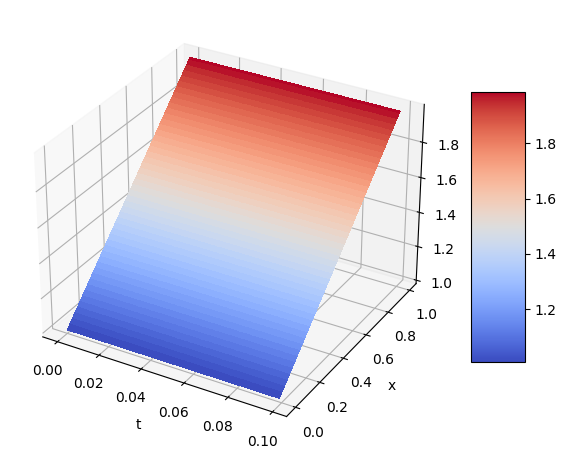

In [21]:
sol.plot2d(func_num=0)

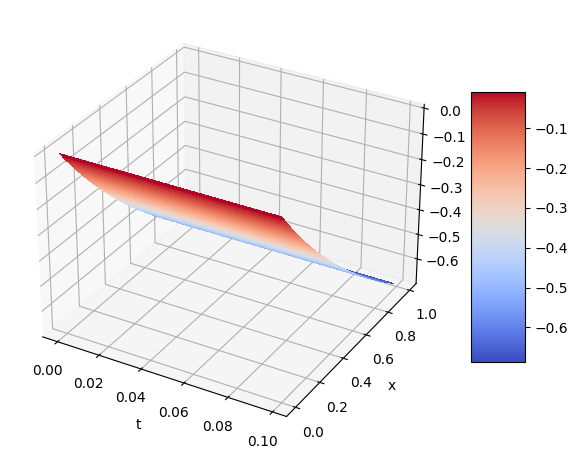

In [22]:
sol.plot2d(func_num=1)